In [1]:
#%matplotlib inline
import random
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
import torchvision.utils as vutils
import torch
import numpy as np
import os
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import math
from utils import plot_training_loss, calculate_fid, generate_images, show_8x8_images
from GAN_model import WGAN_Generator, WGAN_Critic, dcGAN_Generator, dcGAN_Discriminator

In [2]:
# Set random seed for reproducibility
manualSeed = 12
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Random Seed:  12


In [3]:
# Number of workers for dataloader
workers = 12

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [4]:
from torch.utils.data import ConcatDataset

transform = transforms.Compose([
    transforms.CenterCrop(520),
    transforms.Resize((image_size, image_size)),
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.Flowers102(root='./data', split='test', transform=transform, download=True)
testset = torchvision.datasets.Flowers102(root='./data', split='train', transform=transform, download=True)
validdataset = torchvision.datasets.Flowers102(root='./data', split='val', transform=transform, download=True)
dataset = ConcatDataset([trainset, testset, validdataset])

print("訓練集樣本數量:", len(dataset))

訓練集樣本數量: 8189


In [5]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


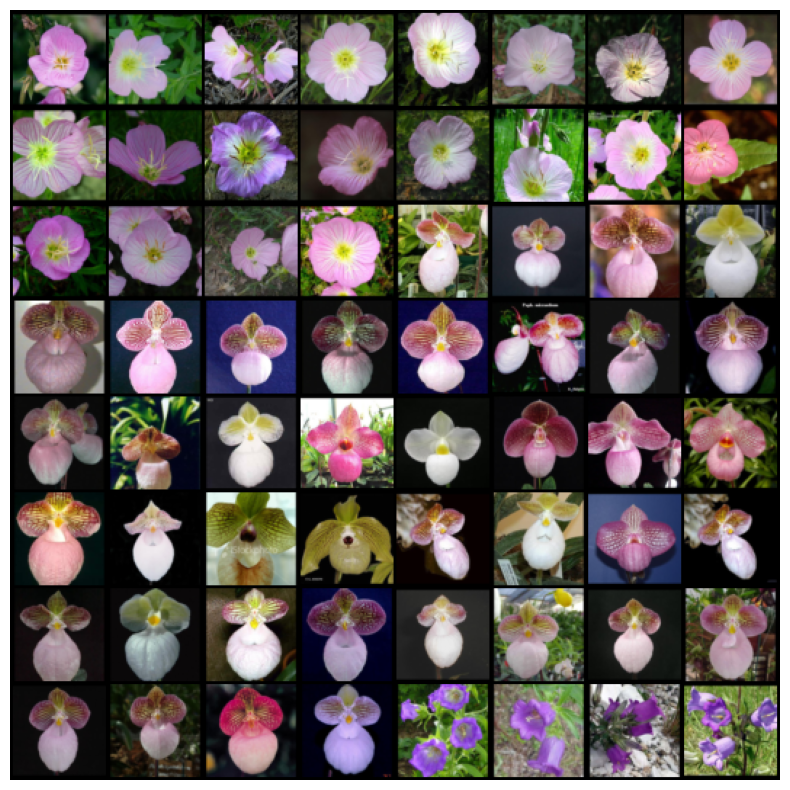

In [6]:
# 準備顯示的圖片
images = [dataset[i][0] for i in range(64)]  # 提取前 64 張圖片

# 使用 make_grid 將圖片拼接成一個網格
grid_image = vutils.make_grid(images, nrow=8, padding=2, normalize=True)

# 顯示圖片
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(grid_image.permute(1, 2, 0))  # 調整圖片通道順序 (C, H, W) -> (H, W, C)
plt.show()

In [7]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
def train_wgan(batch_size, learning_rate, epochs=30):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

    netG = WGAN_Generator(ngpu, nz, ngf, nc, inplace=True).to(device)
    netG.apply(weights_init)
    netC = WGAN_Critic(ngpu, ndf, nc, inplace=True).to(device)
    netC.apply(weights_init)

    clip_value = 0.01
    n_critic = 5

    optimizerG = torch.optim.RMSprop(netG.parameters(), lr=learning_rate)
    optimizerC = torch.optim.RMSprop(netC.parameters(), lr=learning_rate)

    G_losses = []
    C_losses = []

    print("Starting Training Loop...")

    for epoch in range(epochs):
        for i, data in enumerate(dataloader, 0):
            ############################
            # 更新 Critic
            ###########################
            # for _ in range(n_critic):
            netC.zero_grad()
            real_data = data[0].to(device)
            b_size = real_data.size(0)
            
            # 訓練真實樣本
            real_scores = netC(real_data)
            
            # 訓練偽造樣本
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_data = netG(noise).detach()
            fake_scores = netC(fake_data)
            
            # 計算 WGAN 損失
            loss_C = -torch.mean(real_scores) + torch.mean(fake_scores)
            loss_C.backward()
            optimizerC.step()

            # 權重裁剪
            for p in netC.parameters():
                p.data.clamp_(-clip_value, clip_value)

            ############################
            # 更新 Generator
            ###########################
            if i % n_critic == 0:  # 每訓練 5 次 Critic，才更新一次 Generator
                netG.zero_grad()
                noise = torch.randn(b_size, nz, 1, 1, device=device)
                fake_data = netG(noise)
                fake_scores = netC(fake_data)
                
                # 計算 Generator 的 WGAN 損失
                loss_G = -torch.mean(fake_scores)
                loss_G.backward()
                optimizerG.step()

            # 儲存損失歷史
            G_losses.append(loss_G.item())
            C_losses.append(loss_C.item())

        # 輸出訓練情況
        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (epoch + 1, epochs, loss_C.item(), loss_G.item(), real_scores.mean().item(), fake_scores.mean().item(), fake_scores.mean().item()))
                
    resized_folder_path = './resized/'
    generated_images_folder = './GENIMG/'
    generate_images(len(dataset), netG, nz, device, output_dir=generated_images_folder)
    fid_value = calculate_fid(resized_folder_path, generated_images_folder, batch_size, device, num_workers=workers)

    generator_params = netG.state_dict()
    critic_params = netC.state_dict()
                
    return fid_value, G_losses, C_losses, generator_params, critic_params

In [ ]:
def train_dcgan(batch_size, learning_rate, epochs=30):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers, pin_memory=True)

    netG = dcGAN_Generator(ngpu, nz, ngf, nc, inplace=True).to(device)
    netG.apply(weights_init)
    netD = dcGAN_Discriminator(ngpu, ndf, nc, inplace=True).to(device)
    netD.apply(weights_init)

    criterion = nn.BCELoss()

    real_label = 1.
    fake_label = 0.

    optimizerG = torch.optim.Adam(netG.parameters(), lr=learning_rate / 2, betas=(beta1, 0.999))
    optimizerD = torch.optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))

    G_losses = []
    D_losses = []

    for epoch in range(epochs):
        for i, data in enumerate(dataloader, 0):
            ############################
            # 更新 Critic
            ###########################
            netD.zero_grad()
            real_data = data[0].to(device)
            b_size = real_data.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

            output = netD(real_data).view(-1)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_data = netG(noise)
            label.fill_(fake_label)
            output = netD(fake_data.detach()).view(-1)
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()

            errD = errD_real + errD_fake
            optimizerD.step()

            ############################
            # 更新 Generator
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            output = netD(fake_data).view(-1)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            G_losses.append(errG.item())
            D_losses.append(errD.item())

        print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (epoch, epochs, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))


    resized_folder_path = './resized/'
    generated_images_folder = './GENIMG/'
    generate_images(len(dataset), netG, nz, device, output_dir=generated_images_folder)
    fid_value = calculate_fid(resized_folder_path, generated_images_folder, batch_size, device, num_workers=workers)

    generator_params = netG.state_dict()
    discriminator_params = netD.state_dict()

    return fid_value, G_losses, D_losses, generator_params, discriminator_params

In [10]:
import itertools

def grid_search(train_function, batch_sizes, learning_rates, epochs):
    results = []

    # 網格搜索
    for bs, lr in itertools.product(batch_sizes, learning_rates):
        torch.cuda.empty_cache()
        print(f"Training with Batch Size: {bs}, Learning Rate: {lr}")
        fid_value, G_losses, D_losses, generator_params, discriminator_params = train_function(bs, lr, epochs)
        result = {
            "G_losses": G_losses,
            "D_losses": D_losses,
            "generator_params": generator_params,
            "discriminator_params": discriminator_params
        }
        results.append((bs, lr, fid_value, result))

    # 根據驗證損失排序，選擇損失最小的組合
    best_params = min(results, key=lambda x: x[2])
    print("Best Hyperparameters:")
    print(f"Batch Size: {best_params[0]}, Learning Rate: {best_params[1]}, FID value: {best_params[2]}")

    return best_params

## grid search

In [11]:
batch_sizes = [32, 64, 128]
learning_rates = [0.0002, 0.0001, 0.00005]
num_epochs = 60

## WGAN

In [12]:
wgan_best_params = grid_search(train_wgan, batch_sizes, learning_rates, num_epochs)

Training with Batch Size: 32, Learning Rate: 0.0002
Starting Training Loop...
[1/60]	Loss_D: -1.2196	Loss_G: 0.6396	D(x): 0.6178	D(G(z)): -0.6396 / -0.6396
[2/60]	Loss_D: -0.7160	Loss_G: 0.5793	D(x): 0.4515	D(G(z)): -0.5793 / -0.5793
[3/60]	Loss_D: -1.3079	Loss_G: 0.6738	D(x): 0.6630	D(G(z)): -0.6738 / -0.6738
[4/60]	Loss_D: -1.3691	Loss_G: 0.6879	D(x): 0.6930	D(G(z)): -0.6879 / -0.6879
[5/60]	Loss_D: -1.3507	Loss_G: 0.6902	D(x): 0.6996	D(G(z)): -0.6902 / -0.6902
[6/60]	Loss_D: -1.3827	Loss_G: 0.7028	D(x): 0.6951	D(G(z)): -0.7028 / -0.7028
[7/60]	Loss_D: -1.2943	Loss_G: 0.6802	D(x): 0.6577	D(G(z)): -0.6802 / -0.6802
[8/60]	Loss_D: -1.2509	Loss_G: 0.6902	D(x): 0.6740	D(G(z)): -0.6902 / -0.6902
[9/60]	Loss_D: -1.2691	Loss_G: 0.6697	D(x): 0.6352	D(G(z)): -0.6697 / -0.6697
[10/60]	Loss_D: -1.3055	Loss_G: 0.6769	D(x): 0.6543	D(G(z)): -0.6769 / -0.6769
[11/60]	Loss_D: -1.2820	Loss_G: 0.6394	D(x): 0.6310	D(G(z)): -0.6394 / -0.6394
[12/60]	Loss_D: -1.3067	Loss_G: 0.6563	D(x): 0.6546	D(G(z)): -

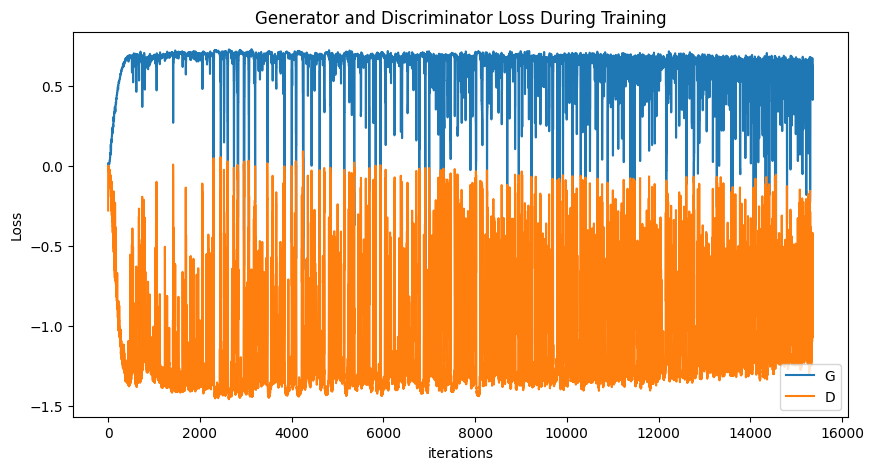

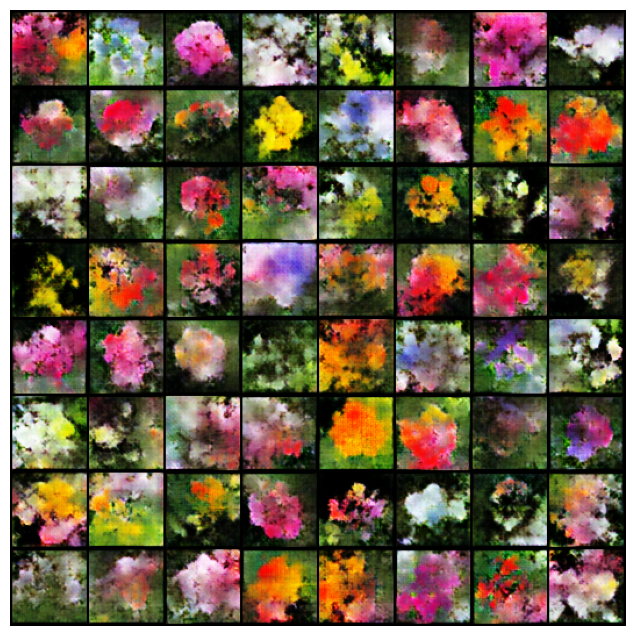

In [13]:
G_losses, D_losses = wgan_best_params[3]['G_losses'], wgan_best_params[3]['D_losses']
plot_training_loss(G_losses, D_losses)

netG = netG = WGAN_Generator(ngpu, nz, ngf, nc, inplace=True).to(device)
netG.load_state_dict(wgan_best_params[3]['generator_params'])
show_8x8_images(netG, nz, device)

Retraining with Best Hyperparameters: Batch Size: 32, Learning Rate: 0.0001, Epochs: 500
Starting Training Loop...
[1/500]	Loss_D: -1.0736	Loss_G: 0.5607	D(x): 0.5049	D(G(z)): -0.5607 / -0.5607
[2/500]	Loss_D: -1.2841	Loss_G: 0.6461	D(x): 0.6204	D(G(z)): -0.6461 / -0.6461
[3/500]	Loss_D: -1.2597	Loss_G: 0.6511	D(x): 0.6343	D(G(z)): -0.6511 / -0.6511
[4/500]	Loss_D: -1.3605	Loss_G: 0.6825	D(x): 0.6860	D(G(z)): -0.6825 / -0.6825
[5/500]	Loss_D: -1.3122	Loss_G: 0.6736	D(x): 0.6241	D(G(z)): -0.6736 / -0.6736
[6/500]	Loss_D: -1.1447	Loss_G: 0.6336	D(x): 0.4319	D(G(z)): -0.6336 / -0.6336
[7/500]	Loss_D: -0.2715	Loss_G: 0.2871	D(x): 0.5794	D(G(z)): -0.2871 / -0.2871
[8/500]	Loss_D: -1.4229	Loss_G: 0.7145	D(x): 0.7210	D(G(z)): -0.7145 / -0.7145
[9/500]	Loss_D: -1.4347	Loss_G: 0.7140	D(x): 0.7200	D(G(z)): -0.7140 / -0.7140
[10/500]	Loss_D: -1.4452	Loss_G: 0.7244	D(x): 0.7276	D(G(z)): -0.7244 / -0.7244
[11/500]	Loss_D: -1.3894	Loss_G: 0.6978	D(x): 0.6990	D(G(z)): -0.6978 / -0.6978
[12/500]	Loss_

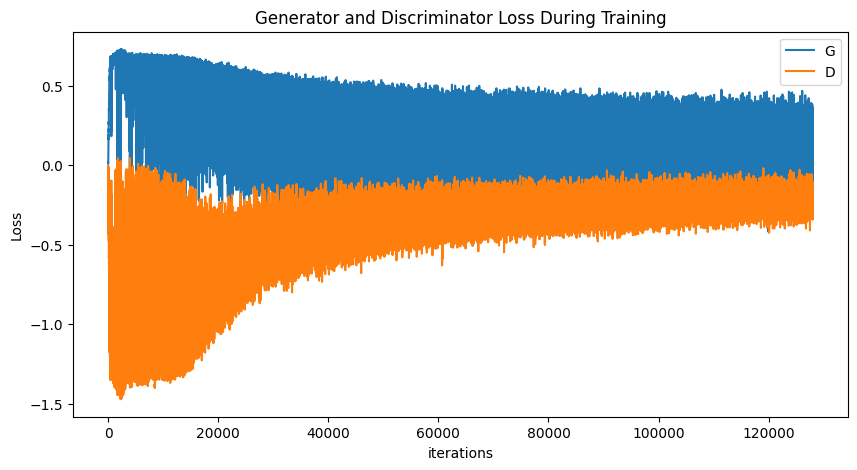

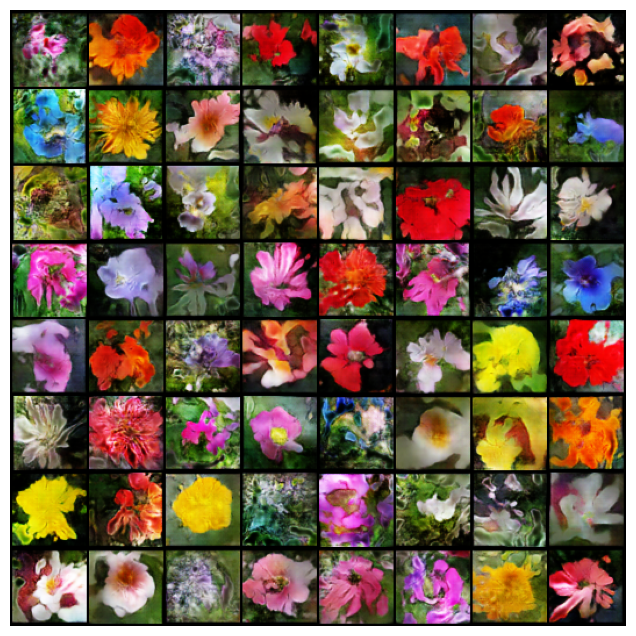

In [14]:
best_batch_size = wgan_best_params[0]
best_learning_rate = wgan_best_params[1]

torch.cuda.empty_cache()
print(f"Retraining with Best Hyperparameters: Batch Size: {best_batch_size}, Learning Rate: {best_learning_rate}, Epochs: 500")

fid_value, G_losses, D_losses, generator_params, discriminator_params = train_wgan(best_batch_size, best_learning_rate, epochs=500)

print(f"FID value: {fid_value}")
plot_training_loss(G_losses, D_losses)

netG = netG = WGAN_Generator(ngpu, nz, ngf, nc, inplace=True).to(device)
netG.load_state_dict(generator_params)
show_8x8_images(netG, nz, device)

## dcGAN

In [15]:
dcgan_best_params = grid_search(train_dcgan, batch_sizes, learning_rates, num_epochs)

Training with Batch Size: 32, Learning Rate: 0.0002
[0/60]	Loss_D: 1.1371	Loss_G: 12.8057	D(x): 0.9878	D(G(z)): 0.5807 / 0.0000
[1/60]	Loss_D: 0.2512	Loss_G: 8.5887	D(x): 0.9710	D(G(z)): 0.1706 / 0.0004
[2/60]	Loss_D: 0.3306	Loss_G: 2.7721	D(x): 0.8109	D(G(z)): 0.0719 / 0.0993
[3/60]	Loss_D: 0.1169	Loss_G: 5.9378	D(x): 0.9171	D(G(z)): 0.0202 / 0.0052
[4/60]	Loss_D: 0.1356	Loss_G: 9.6570	D(x): 0.9815	D(G(z)): 0.0953 / 0.0001
[5/60]	Loss_D: 0.2537	Loss_G: 9.6781	D(x): 0.8281	D(G(z)): 0.0007 / 0.0002
[6/60]	Loss_D: 0.3683	Loss_G: 3.3072	D(x): 0.8585	D(G(z)): 0.1357 / 0.0524
[7/60]	Loss_D: 0.3937	Loss_G: 5.6476	D(x): 0.7345	D(G(z)): 0.0136 / 0.0153
[8/60]	Loss_D: 0.4079	Loss_G: 4.7435	D(x): 0.7356	D(G(z)): 0.0185 / 0.0166
[9/60]	Loss_D: 0.7970	Loss_G: 3.3641	D(x): 0.7240	D(G(z)): 0.2882 / 0.0505
[10/60]	Loss_D: 0.2223	Loss_G: 2.7208	D(x): 0.9027	D(G(z)): 0.1019 / 0.0975
[11/60]	Loss_D: 2.0246	Loss_G: 4.1081	D(x): 0.2519	D(G(z)): 0.0009 / 0.0455
[12/60]	Loss_D: 1.9283	Loss_G: 2.4329	D(x): 0

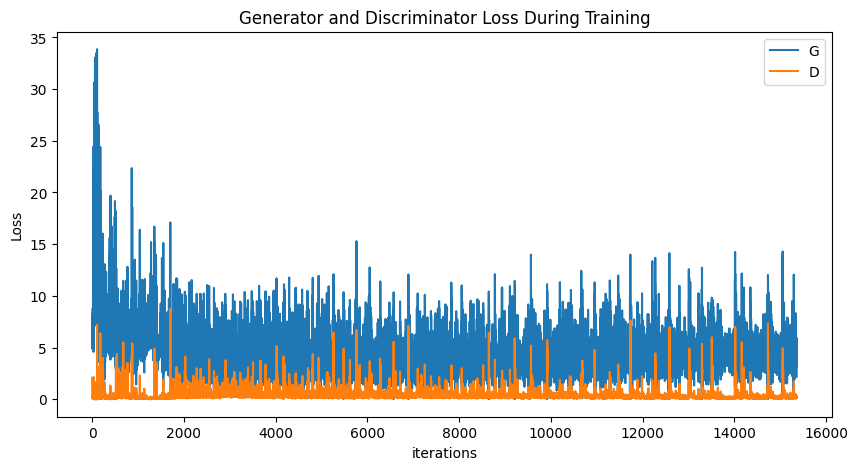

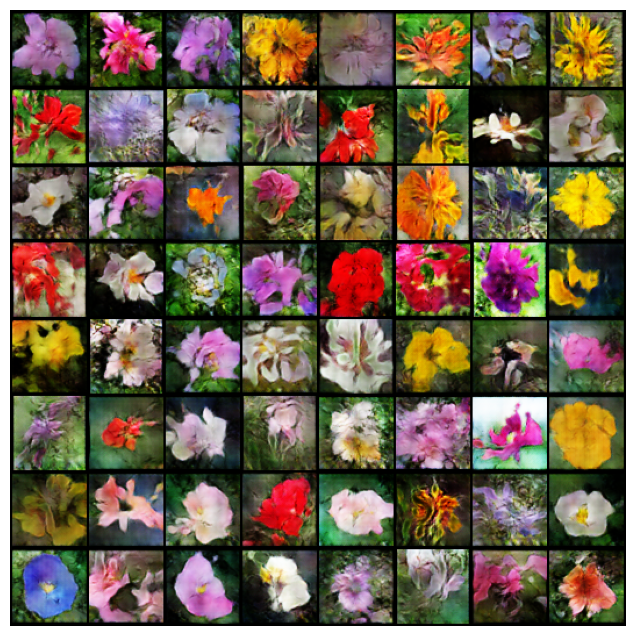

In [16]:
G_losses, D_losses = dcgan_best_params[3]['G_losses'], dcgan_best_params[3]['D_losses']
plot_training_loss(G_losses, D_losses)

netG = netG = dcGAN_Generator(ngpu, nz, ngf, nc, inplace=True).to(device)
netG.load_state_dict(dcgan_best_params[3]['generator_params'])
show_8x8_images(netG, nz, device)

Retraining with Best Hyperparameters: Batch Size: 32, Learning Rate: 0.0002, Epochs: 500
[0/500]	Loss_D: 0.4289	Loss_G: 12.3311	D(x): 0.9022	D(G(z)): 0.2435 / 0.0000
[1/500]	Loss_D: 0.2340	Loss_G: 4.2279	D(x): 0.9089	D(G(z)): 0.1067 / 0.0207
[2/500]	Loss_D: 0.1965	Loss_G: 5.6668	D(x): 0.9527	D(G(z)): 0.1290 / 0.0048
[3/500]	Loss_D: 0.0743	Loss_G: 6.2752	D(x): 0.9651	D(G(z)): 0.0341 / 0.0028
[4/500]	Loss_D: 0.7867	Loss_G: 6.4922	D(x): 0.6481	D(G(z)): 0.0007 / 0.0095
[5/500]	Loss_D: 0.1453	Loss_G: 4.9474	D(x): 0.9586	D(G(z)): 0.0928 / 0.0111
[6/500]	Loss_D: 0.5584	Loss_G: 2.0137	D(x): 0.7119	D(G(z)): 0.1444 / 0.1587
[7/500]	Loss_D: 0.4051	Loss_G: 6.7457	D(x): 0.9145	D(G(z)): 0.2218 / 0.0019
[8/500]	Loss_D: 0.9447	Loss_G: 3.8919	D(x): 0.4797	D(G(z)): 0.0030 / 0.0594
[9/500]	Loss_D: 0.3356	Loss_G: 3.8258	D(x): 0.7719	D(G(z)): 0.0367 / 0.0328
[10/500]	Loss_D: 2.3726	Loss_G: 8.6115	D(x): 0.9928	D(G(z)): 0.8286 / 0.0006
[11/500]	Loss_D: 0.0865	Loss_G: 4.8376	D(x): 0.9532	D(G(z)): 0.0358 / 0.0

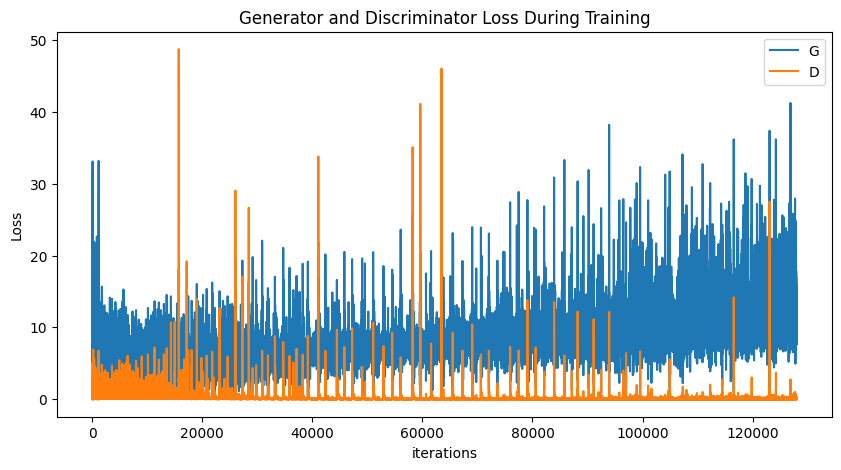

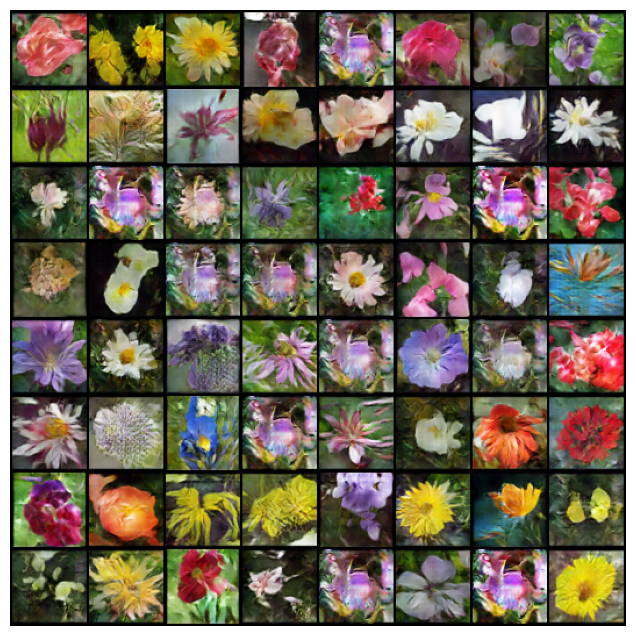

In [17]:
best_batch_size = dcgan_best_params[0]
best_learning_rate = dcgan_best_params[1]

torch.cuda.empty_cache()
print(f"Retraining with Best Hyperparameters: Batch Size: {best_batch_size}, Learning Rate: {best_learning_rate}, Epochs: 500")

fid_value, G_losses, D_losses, generator_params, discriminator_params = train_dcgan(best_batch_size, best_learning_rate, epochs=500)

print(f"FID value: {fid_value}")
plot_training_loss(G_losses, D_losses)

netG = netG = dcGAN_Generator(ngpu, nz, ngf, nc, inplace=True).to(device)
netG.load_state_dict(generator_params)
show_8x8_images(netG, nz, device)